### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# import helper files
from utils import *
from models import *
from plots import *

### Load Dataset

In [2]:
## read in dataset - change directory as needed... n
df = pd.read_csv('calip_dhw_giov.csv')

### 0. Config

In [3]:
## 0.1 Data config
dist_thresh = 10

# target class available: label_baa_7d_max, crw_baa, label, class
tar_class = 'label_baa_7d_max'

# target labels: 0 non-coral, 1 coral
tar_labels = [0, 1]
classes = ('Other', 'Coral')

# target features: calip_only, calip_feats, calip_giov
tar_feats = 'calip_only'

# scaling method: MinMax, MaxAbs, None,  
scaling_method = 'MaxAbs'

# sampling methods available: smote, undersampling, random
sampling_method = 'undersampling'
replacement = True

## 0.2 Model Config 
NUM_EPOCHS = 2
BATCH_SIZE = 64

## 0.3 Path for saving model
PATH_OUTPUT = "../output/"
os.makedirs(PATH_OUTPUT, exist_ok=True)
model_name = 'FF_NN_10m_MinMax_Undersample_replacement'
file_name = model_name + '.pth'

# keep best model
best_val_acc = 0.0

## 1. Data Prep

### 1.1 Data Preprocess

In [4]:
# 1.1 subset data based on user input
data, feat_cols = subset_data(df, dist_thresh, tar_feats, tar_class)

# 1.2 split data to train/test
X_train, y_train, X_test, y_test = class_balance(data, feat_cols, tar_class, tar_labels, sampling_method)

# 1.3 transform data if applicable
X_train_transformed, X_test_transformed = scale_data(X_train, X_test, scaling_method)

C:\Users\knagu\anaconda3\envs\pytorch\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### 1.2 Visualization

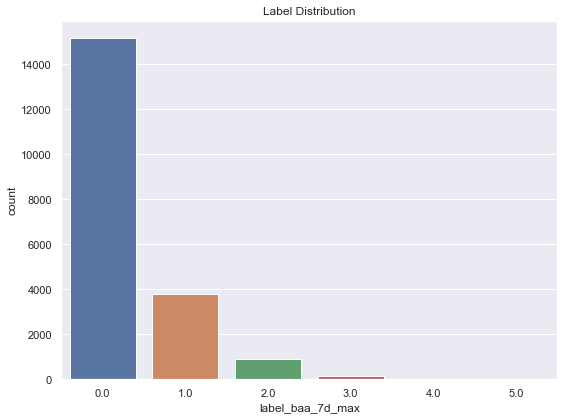

In [5]:
plot_class_balance(data, tar_class)

## 2. Model Setup

In [5]:
# 2.1 Pytorch Data Loader
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

trainset = TensorDataset(torch.from_numpy(X_train_transformed.astype('float32')), 
                         torch.from_numpy(y_train.astype('long')))                        
train_loader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=2)

validset = TensorDataset(torch.from_numpy(X_test_transformed.astype('float32')), 
                        torch.from_numpy(y_test.astype('long')))                        
valid_loader = torch.utils.data.DataLoader(validset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=2)

# 2.2 select FeedForward NN
model = model_selection(tar_feats, tar_labels)

# 2.3 Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 2.4 If GPU is available, we can move the model (all its parameter Tensors) 
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
criterion.to(device)

CrossEntropyLoss()

## 3. Run Model

In [6]:
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
    valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy
    if is_best:
        best_val_acc = valid_accuracy
        torch.save(model, os.path.join(PATH_OUTPUT, file_name), _use_new_zipfile_serialization=False)

Epoch: [0][0/95]	Time 3.477 (3.477)	Data 1.662 (1.662)	Loss 0.6983 (0.6983)	Accuracy 51.562 (51.562)
Epoch: [0][10/95]	Time 0.011 (0.325)	Data 0.002 (0.152)	Loss 0.7284 (0.7185)	Accuracy 40.625 (47.727)
Epoch: [0][20/95]	Time 0.008 (0.175)	Data 0.000 (0.080)	Loss 0.6975 (0.7160)	Accuracy 43.750 (48.363)
Epoch: [0][30/95]	Time 0.017 (0.121)	Data 0.000 (0.054)	Loss 0.7271 (0.7165)	Accuracy 40.625 (48.185)
Epoch: [0][40/95]	Time 0.008 (0.094)	Data 0.000 (0.041)	Loss 0.7154 (0.7150)	Accuracy 54.688 (48.285)
Epoch: [0][50/95]	Time 0.007 (0.077)	Data 0.000 (0.033)	Loss 0.7275 (0.7116)	Accuracy 39.062 (48.866)
Epoch: [0][60/95]	Time 0.007 (0.066)	Data 0.000 (0.028)	Loss 0.6663 (0.7068)	Accuracy 57.812 (49.974)
Epoch: [0][70/95]	Time 0.007 (0.058)	Data 0.001 (0.024)	Loss 0.6612 (0.7041)	Accuracy 67.188 (50.374)
Epoch: [0][80/95]	Time 0.006 (0.051)	Data 0.000 (0.021)	Loss 0.7027 (0.7027)	Accuracy 51.562 (50.617)
Epoch: [0][90/95]	Time 0.008 (0.047)	Data 0.001 (0.019)	Loss 0.6686 (0.7012)	Accura

## 4. Visualize Results

### 4.1 Learning Curve

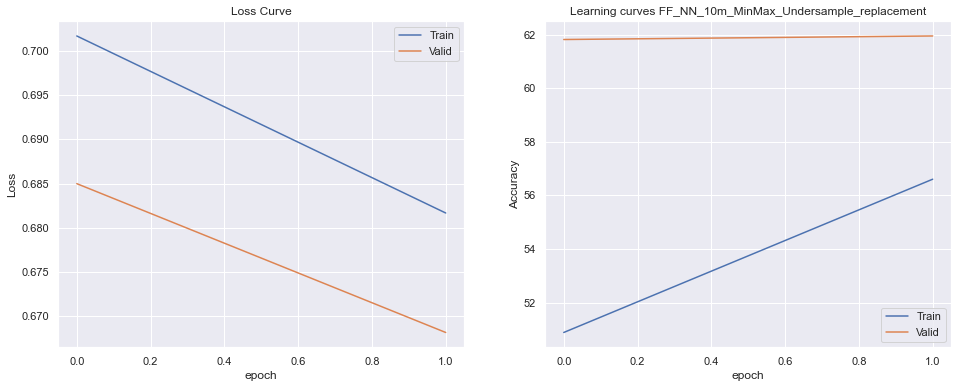

In [7]:
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, model_name) 

### 4.2 Confusion Matrix

<Figure size 864x648 with 0 Axes>

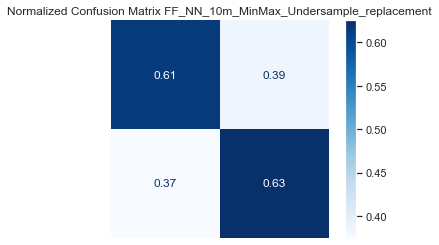

In [9]:
plot_confusion_matrix(valid_results, classes, model_name)